In [1]:
import os
os.environ['HF_HOME'] = '/om/user/ericjm/.cache/huggingface'
import argparse
import time

from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import datasets
from huggingface_hub import hf_hub_download, notebook_login

In [2]:
class JumpReLUSAE(nn.Module):
    def __init__(self, d_model, d_sae):
        # Note that we initialise these to zeros because we're loading in pre-trained weights.
        # If you want to train your own SAEs then we recommend using blah
        super().__init__()
        self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
        self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
        self.threshold = nn.Parameter(torch.zeros(d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))
        self.b_dec = nn.Parameter(torch.zeros(d_model))

    def encode(self, input_acts):
        pre_acts = input_acts @ self.W_enc + self.b_enc
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        return acts

    def decode(self, acts):
        return acts @ self.W_dec + self.b_dec

    def forward(self, acts):
        acts = self.encode(acts)
        recon = self.decode(acts)
        return recon

def gather_residual_activations(model, target_layer, inputs):
    target_act = None
    def gather_target_act_hook(mod, inputs, outputs):
        nonlocal target_act # make sure we can modify the target_act from the outer scope
        target_act = outputs[0]
        return outputs
    handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
    _ = model.forward(inputs)
    handle.remove()
    return target_act

In [3]:
# set grads to off
torch.set_grad_enabled(False)

In [4]:
args = argparse.Namespace()
args.model = "google/gemma-2-2b"
args.layer = 12
args.sae_name = "layer_12/width_16k/average_l0_41"
args.k = 256
args.n_docs = 50_000

In [5]:
DATASET = "monology/pile-uncopyrighted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32 
device_map = {'': 0} if device.type == 'cuda' else None

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    args.model,
    device_map=device_map,
    torch_dtype=dtype,
    low_cpu_mem_usage=True,
)
tokenizer =  AutoTokenizer.from_pretrained(args.model)

Loading model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
if args.model == "google/gemma-2-2b":
    repo_id = "google/gemma-scope-2b-pt-res"
elif args.model == "google/gemma-2-9b":
    repo_id = "google/gemma-scope-9b-pt-res"
path_to_params = hf_hub_download(
    repo_id=repo_id,
    filename=args.sae_name + "/params.npz",
    force_download=False,
    revision="0127b340ca980c3ee81df0275cea35f350f83488",
)

print("Loading SAE from disk...")
params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}

sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1])
sae.load_state_dict(pt_params)

sae.to(device)
sae.eval()

Loading SAE from disk...


JumpReLUSAE()

In [7]:
print("Loading dataset...")
dataset = datasets.load_dataset(DATASET, streaming=True, split="train")

Loading dataset...


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
# tsne projection
# W_dec_tsne = np.load(f"W_dec_tsne_res_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.npy")
# W_dec_tsne = np.load(f"W_dec_tsne_res")
W_dec_tsne = np.load("W_dec_tsne_gemma-2-2b_res_layer_12_width_16k_average_l0_41.npy")

In [9]:
# load up occurrence and co-occurrence data
occurrence_npz = np.load(f"../experiments/all-occurrences0/histograms/pile_{args.model.replace('/', '_')}_res_{args.sae_name.replace('/', '_')}_occurrences.npz")
occurrence_hist, occurrence_n_tokens = occurrence_npz['histogram'], occurrence_npz['n_tokens']

In [10]:
n_clusterss = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
clustering_results_phi = {}
for n_clusters in n_clusterss:
    clustering_results_phi[n_clusters] = np.load(f"../experiments/all-occurrences0/lily/phi/layer_12_{n_clusters}.npy")

In [11]:
# add the n_clusters = 3 case
clustering_results_phi[3] = np.load("../experiments/all-occurrences0/clusters_phi/pile_google_gemma-2-2b_res_layer_12_width_16k_average_l0_41_docs50k_keq256_cooccurrences_phi_3clusters.npz")['3']

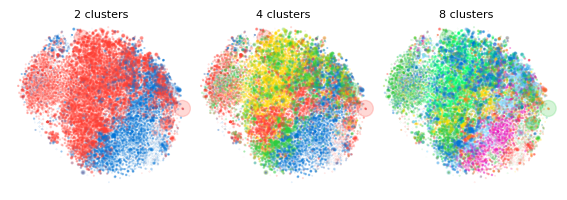

In [11]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']


frequencies = occurrence_hist / occurrence_n_tokens
frequencies[frequencies == 0] = 1e-7

n_clusterss_plot = [2, 4, 8]

plt.figure(figsize=(5.5, 5.5*1/3))

for i, n_clusters in enumerate(n_clusterss_plot):
    plt.subplot(1, 3, i+1)

    clusters = clustering_results_phi[n_clusters]
    cs = [colors[clusteri] for clusteri in clusters]
    cs = np.array(cs)
    n_splits = 20
    splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
    for split in splits:
        plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
            s=frequencies[split]*3e2,
            color=cs[split], 
            alpha=0.2)
    plt.title(f"{n_clusters} clusters", fontsize=8, pad=-10)
    plt.axis('off')

plt.tight_layout(pad=0.1)

In [12]:
doc = next(iter(dataset))

In [13]:
from itertools import islice
types = []
for doc in islice(dataset, 10000):
    types.append(doc['meta']['pile_set_name'])


In [14]:
set(types)

{'ArXiv',
 'DM Mathematics',
 'Enron Emails',
 'EuroParl',
 'FreeLaw',
 'Github',
 'Gutenberg (PG-19)',
 'HackerNews',
 'NIH ExPorter',
 'PhilPapers',
 'Pile-CC',
 'PubMed Abstracts',
 'PubMed Central',
 'StackExchange',
 'USPTO Backgrounds',
 'Ubuntu IRC',
 'Wikipedia (en)'}

In [15]:
from collections import defaultdict

In [21]:
lobe_features2 = {l: set() for l in range(2)}
lobe_features3 = {l: set() for l in range(3)}  # Added 3-lobes
lobe_features4 = {l: set() for l in range(4)}
lobe_features8 = {l: set() for l in range(8)}

for i in range(len(clustering_results_phi[2])):
    lobe_features2[clustering_results_phi[2][i]].add(i)
for i in range(len(clustering_results_phi[3])):  # Added 3-lobes
    lobe_features3[clustering_results_phi[3][i]].add(i)
for i in range(len(clustering_results_phi[4])):
    lobe_features4[clustering_results_phi[4][i]].add(i)
for i in range(len(clustering_results_phi[8])):
    lobe_features8[clustering_results_phi[8][i]].add(i)

winning_lobes2 = defaultdict(list)
winning_lobes3 = defaultdict(list)  # Added 3-lobes
winning_lobes4 = defaultdict(list)
winning_lobes8 = defaultdict(list)

n_docs = 10_000
for doc in tqdm(islice(dataset, n_docs), total=n_docs):
    # get SAE activations
    inputs = tokenizer.encode(
        doc['text'], 
        return_tensors="pt", 
        add_special_tokens=True,
        max_length=1024,  
        truncation=True
    ).to(device)
    doc_type = doc['meta']['pile_set_name']
    target_act = gather_residual_activations(model, args.layer, inputs)
    sae_acts = sae.encode(target_act)
    # convert to 0 or 1 (depending on whether activations are above 1)
    sae_acts = (sae_acts > 1).float() # shape (1, seq_len, d_sae)
    sae_acts = sae_acts[0, 1:] # remove the BOS token
    for j in range(0, sae_acts.shape[0], args.k):
        if j + args.k <= sae_acts.shape[0]:
            chunk = sae_acts[j:j+args.k]
            chunk_features = torch.any(chunk, dim=0).nonzero()
            chunk_features = set(chunk_features.flatten().tolist())
            # compute the size of the intersection with each lobe
            lobe_proportions2 = {
                l: len(lobe_features2[l].intersection(chunk_features)) / len(lobe_features2[l])
                for l in range(2)
            }
            lobe_proportions3 = {  # Added 3-lobes
                l: len(lobe_features3[l].intersection(chunk_features)) / len(lobe_features3[l])
                for l in range(3)
            }
            lobe_proportions4 = {
                l: len(lobe_features4[l].intersection(chunk_features)) / len(lobe_features4[l])
                for l in range(4)
            }
            lobe_proportions8 = {
                l: len(lobe_features8[l].intersection(chunk_features)) / len(lobe_features8[l])
                for l in range(8)
            }
            # find the lobe with the highest proportion
            winning_lobe2 = max(lobe_proportions2, key=lobe_proportions2.get)
            winning_lobe3 = max(lobe_proportions3, key=lobe_proportions3.get)  # Added 3-lobes
            winning_lobe4 = max(lobe_proportions4, key=lobe_proportions4.get)
            winning_lobe8 = max(lobe_proportions8, key=lobe_proportions8.get)
            winning_lobes2[doc_type].append(winning_lobe2)
            winning_lobes3[doc_type].append(winning_lobe3)  # Added 3-lobes
            winning_lobes4[doc_type].append(winning_lobe4)
            winning_lobes8[doc_type].append(winning_lobe8)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
# save the winning_lobes statistics
import pickle
with open(f"winning_lobes2_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "wb") as f:
    pickle.dump(winning_lobes2, f)
with open(f"winning_lobes3_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "wb") as f:
    pickle.dump(winning_lobes3, f)
with open(f"winning_lobes4_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "wb") as f:
    pickle.dump(winning_lobes4, f)
with open(f"winning_lobes8_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "wb") as f:
    pickle.dump(winning_lobes8, f)

In [16]:
# load 
import pickle
with open(f"winning_lobes2_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "rb") as f:
    winning_lobes2 = pickle.load(f)
with open(f"winning_lobes3_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "rb") as f:
    winning_lobes3 = pickle.load(f)
with open(f"winning_lobes4_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "rb") as f:
    winning_lobes4 = pickle.load(f)
with open(f"winning_lobes8_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}.pkl", "rb") as f:
    winning_lobes8 = pickle.load(f)

In [17]:
# get the winning_lobes2
assignments2 = {
    l: [] for l in range(2)
}
for doc_type, lobe_assignments in winning_lobes2.items():
    lobe = max(set(lobe_assignments), key=lobe_assignments.count)
    assignments2[lobe].append(doc_type)

assignments3 = {
    l: [] for l in range(3)
}
for doc_type, lobe_assignments in winning_lobes3.items():
    lobe = max(set(lobe_assignments), key=lobe_assignments.count)
    assignments3[lobe].append(doc_type)

# get the winning_lobes4
assignments4 = {
    l: [] for l in range(4)
}
for doc_type, lobe_assignments in winning_lobes4.items():
    lobe = max(set(lobe_assignments), key=lobe_assignments.count)
    assignments4[lobe].append(doc_type)

In [18]:
assignments2

{0: ['Pile-CC',
  'Wikipedia (en)',
  'PubMed Abstracts',
  'USPTO Backgrounds',
  'FreeLaw',
  'PubMed Central',
  'HackerNews',
  'NIH ExPorter',
  'ArXiv',
  'Enron Emails',
  'Ubuntu IRC',
  'PhilPapers',
  'Gutenberg (PG-19)',
  'EuroParl'],
 1: ['Github', 'StackExchange', 'DM Mathematics']}

In [19]:
assignments3

{0: ['Pile-CC',
  'USPTO Backgrounds',
  'HackerNews',
  'Enron Emails',
  'Ubuntu IRC',
  'PhilPapers',
  'EuroParl'],
 1: ['Wikipedia (en)',
  'PubMed Abstracts',
  'FreeLaw',
  'PubMed Central',
  'NIH ExPorter',
  'ArXiv',
  'Gutenberg (PG-19)'],
 2: ['Github', 'StackExchange', 'DM Mathematics']}

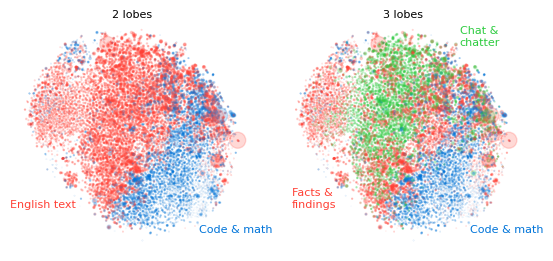

In [35]:
# colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
#           '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']
colors = ['#FF4136', '#0074D9', '#2ECC40']

frequencies = occurrence_hist / occurrence_n_tokens
frequencies[frequencies == 0] = 1e-7

n_clusterss_plot = [2, 4]

plt.figure(figsize=(5.5, 2.5))

plt.subplot(1, 2, 1)
clusters = clustering_results_phi[2]
cs = [colors[clusteri] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"{2} lobes", fontsize=8, pad=-10)

plt.text(
    -60, -30,
    "English text",
    color=colors[0],
    fontsize=8,
)

plt.text(
    30, -40,
    "Code & math",
    color=colors[1],
    fontsize=8,
)


plt.axis('off')




plt.subplot(1, 2, 2)
clusters = clustering_results_phi[3]
cperm = np.array([2, 0, 1]) 
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"{3} lobes", fontsize=8, pad=-10)

# text = ""
# for i in range(min(4, len(assignments4[0]))):
#     text += assignments4[0][i] + "\n"
# if len(assignments4[0]) > 4:
#     text += "..."
# plt.text(
#     -70, -30,
#     text,
#     color=colors[0],
#     fontsize=5,
# )

# text = ""
# for i in range(min(4, len(assignments4[1]))):
#     text += assignments4[1][i] + "\n"
# if len(assignments4[1]) > 4:
#     text += "..."
# plt.text(
#     30, -50,
#     text,
#     color=colors[1],
#     fontsize=5,
# )

# text = ""
# for i in range(min(4, len(assignments4[2]))):
#     text += assignments4[2][i] + "\n"
# if len(assignments4[2]) > 4:
#     text += "..."
# plt.text(
#     20, 33,
#     text,
#     color=colors[2],
#     fontsize=5,
# )

plt.text(
    25, 33,
    "Chat &\nchatter",
    color=colors[2],
    fontsize=8,
)

plt.text(
    -55, -30,
    "Facts &\nfindings",
    color=colors[0],
    fontsize=8,
)


# text = ""
# for i in range(min(4, len(assignments4[3]))):
#     text += assignments4[3][i] + "\n"
# if len(assignments4[3]) > 4:
#     text += "..."
# plt.text(
#     -50, -50,
#     text,
#     color=colors[3],
#     fontsize=5,
# )

plt.text(
    30, -40,
    "Code & math",
    color=colors[1],
    fontsize=8,
)

plt.axis('off')

plt.tight_layout(pad=0.3)
plt.savefig("lobe-annotations2and3.jpg", dpi=500)

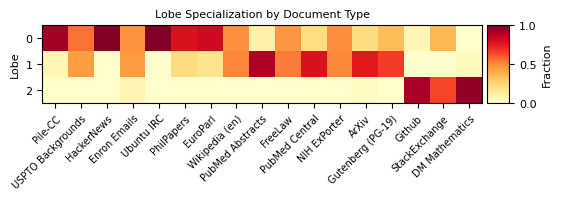

In [53]:
# heat map plot of the winning_lobe statistics
# on the y axis we will have lobe
# on the x axis we will have document type
# color of the cell will be the proportion of the document type that was assigned to the lobe
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# order the doc_types by lobe assignment for the 3-lobe case
doc_types = []
for i in range(3):
    doc_types.extend(assignments3[i])

data = winning_lobes3  # Make sure this variable is defined in your notebook

# Compute fractions
fractions = {}

for doc_type in doc_types:
    lobe_assignments = data[doc_type]
    total = len(lobe_assignments)
    counter = Counter(lobe_assignments)
    fractions[doc_type] = {lobe: count/total for lobe, count in counter.items()}

# Prepare data for heatmap
lobes = sorted(set(lobe for doc_fractions in fractions.values() for lobe in doc_fractions.keys()))

matrix = np.zeros((len(lobes), len(doc_types)))
for i, doc_type in enumerate(doc_types):
    for j, lobe in enumerate(lobes):
        matrix[j, i] = fractions[doc_type].get(lobe, 0)

# Create heatmap
fig, ax = plt.subplots(figsize=(5.5, 4))
im = ax.imshow(matrix, cmap='YlOrRd')

ax.set_xticks(np.arange(len(doc_types)))
ax.set_yticks(np.arange(len(lobes)))
ax.set_xticklabels(doc_types, fontsize=7)
ax.set_yticklabels(lobes, fontsize=8)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# ax.set_xlabel('Document Type')
ax.set_ylabel('Lobe', fontsize=8)
ax.set_title('Lobe Specialization by Document Type', fontsize=8)

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)

# Add an axes to the right of the main axes
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create the colorbar in the newly created axes
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Fraction', fontsize=8)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout(pad=0.2)
plt.savefig("lobe-heatmap3.png", dpi=300)

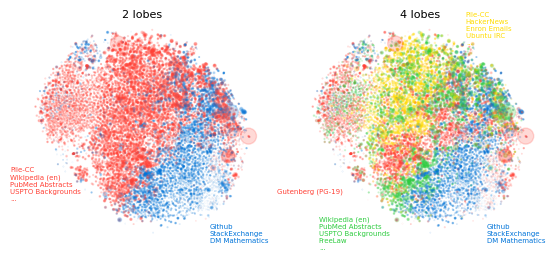

In [24]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']


frequencies = occurrence_hist / occurrence_n_tokens
frequencies[frequencies == 0] = 1e-7

n_clusterss_plot = [2, 4]

plt.figure(figsize=(5.5, 2.5))

plt.subplot(1, 2, 1)
clusters = clustering_results_phi[2]
cs = [colors[clusteri] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"{2} lobes", fontsize=8, pad=-10)

text = ""
for i in range(min(4, len(assignments2[0]))):
    text += assignments2[0][i] + "\n"
if len(assignments2[0]) > 4:
    text += "..."
plt.text(
    -65, -30,
    text,
    color=colors[0],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments2[1]))):
    text += assignments2[1][i] + "\n"
if len(assignments2[1]) > 4:
    text += "..."
plt.text(
    30, -50,
    text,
    color=colors[1],
    fontsize=5,
)


plt.axis('off')




plt.subplot(1, 2, 2)
clusters = clustering_results_phi[4]
cs = [colors[clusteri] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"{4} lobes", fontsize=8, pad=-10)

text = ""
for i in range(min(4, len(assignments4[0]))):
    text += assignments4[0][i] + "\n"
if len(assignments4[0]) > 4:
    text += "..."
plt.text(
    -70, -30,
    text,
    color=colors[0],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments4[1]))):
    text += assignments4[1][i] + "\n"
if len(assignments4[1]) > 4:
    text += "..."
plt.text(
    30, -50,
    text,
    color=colors[1],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments4[2]))):
    text += assignments4[2][i] + "\n"
if len(assignments4[2]) > 4:
    text += "..."
plt.text(
    20, 33,
    text,
    color=colors[2],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments4[3]))):
    text += assignments4[3][i] + "\n"
if len(assignments4[3]) > 4:
    text += "..."
plt.text(
    -50, -50,
    text,
    color=colors[3],
    fontsize=5,
)

plt.axis('off')

plt.tight_layout(pad=0.3)
plt.savefig("lobe-annotations.png", dpi=400)

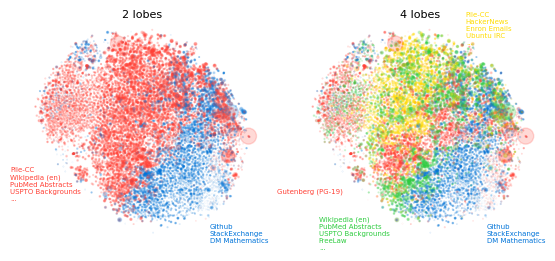

In [26]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']


frequencies = occurrence_hist / occurrence_n_tokens
frequencies[frequencies == 0] = 1e-7

n_clusterss_plot = [2, 4]

plt.figure(figsize=(5.5, 2.5))

plt.subplot(1, 2, 1)
clusters = clustering_results_phi[2]
cs = [colors[clusteri] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"{2} lobes", fontsize=8, pad=-10)

text = ""
for i in range(min(4, len(assignments2[0]))):
    text += assignments2[0][i] + "\n"
if len(assignments2[0]) > 4:
    text += "..."
plt.text(
    -65, -30,
    text,
    color=colors[0],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments2[1]))):
    text += assignments2[1][i] + "\n"
if len(assignments2[1]) > 4:
    text += "..."
plt.text(
    30, -50,
    text,
    color=colors[1],
    fontsize=5,
)


plt.axis('off')




plt.subplot(1, 2, 2)
clusters = clustering_results_phi[4]
cs = [colors[clusteri] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"{4} lobes", fontsize=8, pad=-10)

text = ""
for i in range(min(4, len(assignments4[0]))):
    text += assignments4[0][i] + "\n"
if len(assignments4[0]) > 4:
    text += "..."
plt.text(
    -70, -30,
    text,
    color=colors[0],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments4[1]))):
    text += assignments4[1][i] + "\n"
if len(assignments4[1]) > 4:
    text += "..."
plt.text(
    30, -50,
    text,
    color=colors[1],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments4[2]))):
    text += assignments4[2][i] + "\n"
if len(assignments4[2]) > 4:
    text += "..."
plt.text(
    20, 33,
    text,
    color=colors[2],
    fontsize=5,
)

text = ""
for i in range(min(4, len(assignments4[3]))):
    text += assignments4[3][i] + "\n"
if len(assignments4[3]) > 4:
    text += "..."
plt.text(
    -50, -50,
    text,
    color=colors[3],
    fontsize=5,
)

plt.axis('off')

plt.tight_layout(pad=0.3)
plt.savefig("lobe-annotations.jpg", dpi=700)

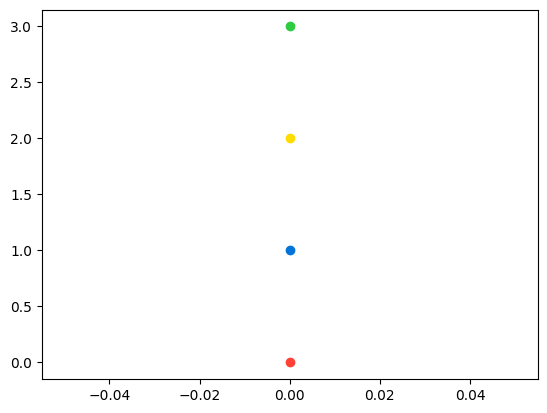

In [39]:
plt.scatter([0], [0], color=colors[0], label="Lobe 0")
plt.scatter([0], [1], color=colors[1], label="Lobe 1")
plt.scatter([0], [2], color=colors[2], label="Lobe 2")
plt.scatter([0], [3], color=colors[3], label="Lobe 3")

In [27]:
assignments4

{0: ['Gutenberg (PG-19)'],
 1: ['Github', 'StackExchange', 'DM Mathematics'],
 2: ['Pile-CC', 'HackerNews', 'Enron Emails', 'Ubuntu IRC', 'EuroParl'],
 3: ['Wikipedia (en)',
  'PubMed Abstracts',
  'USPTO Backgrounds',
  'FreeLaw',
  'PubMed Central',
  'NIH ExPorter',
  'ArXiv',
  'PhilPapers']}

In [25]:
assignments2

{0: ['Pile-CC',
  'Wikipedia (en)',
  'PubMed Abstracts',
  'USPTO Backgrounds',
  'FreeLaw',
  'PubMed Central',
  'HackerNews',
  'NIH ExPorter',
  'ArXiv',
  'Enron Emails',
  'Ubuntu IRC',
  'PhilPapers',
  'Gutenberg (PG-19)',
  'EuroParl'],
 1: ['Github', 'StackExchange', 'DM Mathematics']}

In [22]:
winning_lobes2['Pile-CC']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [40]:
len(lobe_features[0]), len(lobe_features[1])

(10923, 5461)

{2,
 3,
 8194,
 5,
 8199,
 10,
 8205,
 8209,
 8214,
 8218,
 30,
 33,
 8229,
 8230,
 40,
 44,
 8238,
 8239,
 51,
 8243,
 58,
 60,
 63,
 8258,
 67,
 8260,
 73,
 8274,
 83,
 101,
 104,
 8301,
 112,
 8311,
 8312,
 123,
 8315,
 8318,
 132,
 138,
 144,
 145,
 8337,
 8338,
 8344,
 156,
 8358,
 8359,
 170,
 8368,
 177,
 178,
 8369,
 8372,
 185,
 188,
 8386,
 200,
 8395,
 8397,
 8398,
 207,
 209,
 212,
 8407,
 8408,
 217,
 218,
 220,
 221,
 8412,
 8414,
 225,
 8417,
 230,
 8422,
 8430,
 239,
 8433,
 242,
 244,
 8441,
 250,
 252,
 8444,
 8445,
 255,
 256,
 257,
 8450,
 8452,
 264,
 265,
 8457,
 8461,
 8463,
 8464,
 274,
 8467,
 276,
 277,
 8472,
 285,
 287,
 289,
 293,
 294,
 304,
 305,
 8502,
 314,
 8507,
 8510,
 8517,
 8518,
 8519,
 328,
 331,
 335,
 336,
 8528,
 8530,
 8535,
 344,
 345,
 8539,
 8543,
 356,
 8553,
 366,
 368,
 8560,
 371,
 375,
 386,
 389,
 8584,
 394,
 8586,
 8593,
 8598,
 8603,
 415,
 418,
 8611,
 422,
 8618,
 8619,
 8623,
 443,
 445,
 8640,
 8641,
 454,
 8646,
 8648,
 8658,

In [29]:
doc = next(iter(dataset))
inputs = tokenizer.encode(
    doc['text'], 
    return_tensors="pt", 
    add_special_tokens=True,
    max_length=1024,  
    truncation=True  # Add this line
).to(device)

target_act = gather_residual_activations(model, args.layer, inputs)
sae_acts = sae.encode(target_act)
# convert to 0 or 1 (depending on whether activations are above 1)
sae_acts = (sae_acts > 1).float() # shape (1, seq_len, d_sae)
sae_acts = sae_acts[0, 1:] # remove the BOS token

i = 0
chunk = sae_acts[i:i+args.k]
chunk_features = torch.any(chunk, dim=0)

n_clusters = 10
cluster_histogram = torch.zeros(n_clusters, dtype=torch.int32)
for j in chunk_features.nonzero()[:, 0].tolist():
    cluster = clustering_results[n_clusters][j]
    cluster_histogram[cluster] += 1

In [40]:
# count the number of elements in each cluster
histogram_baseline = np.histogram(clustering_results[n_clusters], bins=n_clusters)[0]

<BarContainer object of 10 artists>

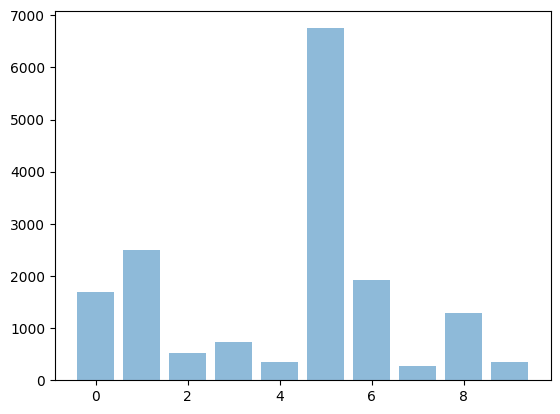

In [41]:
plt.bar(np.arange(n_clusters), histogram_baseline, alpha=0.5, label="Baseline")

<BarContainer object of 10 artists>

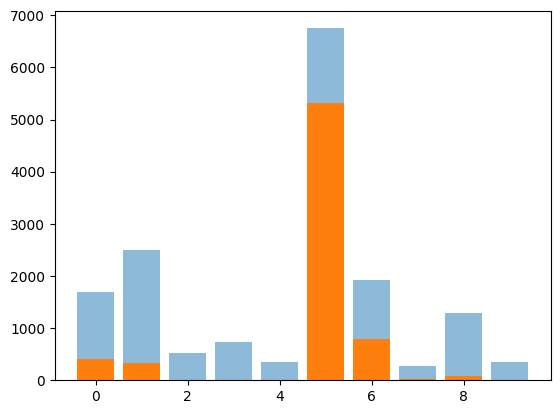

In [42]:
# plot histogram
import matplotlib.pyplot as plt
plt.bar(np.arange(n_clusters), histogram_baseline, alpha=0.5, label="Chunk")
plt.bar(range(n_clusters), cluster_histogram, color='C1')

In [51]:
# compute these histograms for the first 1000 documents, and also save the texts

n_clusters = 10

texts = []
cluster_histograms = []
for i, doc in enumerate(tqdm(dataset, total=1000)):
    inputs = tokenizer.encode(
        doc['text'], 
        return_tensors="pt", 
        add_special_tokens=True,
        max_length=1024,  
        truncation=True  # Add this line
    ).to(device)

    target_act = gather_residual_activations(model, args.layer, inputs)
    sae_acts = sae.encode(target_act)
    # convert to 0 or 1 (depending on whether activations are above 1)
    sae_acts = (sae_acts > 1).float() # shape (1, seq_len, d_sae)
    sae_acts = sae_acts[0, 1:] # remove the BOS token

    chunk = sae_acts[i:i+args.k]
    chunk_features = torch.any(chunk, dim=0)

    cluster_histogram = torch.zeros(n_clusters, dtype=torch.int32)
    for j in chunk_features.nonzero()[:, 0].tolist():
        cluster = clustering_results[n_clusters][j]
        cluster_histogram[cluster] += 1

    cluster_histograms.append(cluster_histogram)
    # for the text, decode the input_ids
    text = tokenizer.decode(inputs[0, 1:][i:i+args.k])
    texts.append(text)

    if i == 1000:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

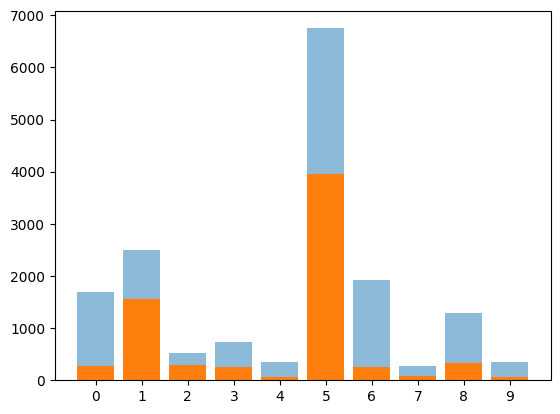

In [142]:
# plot histogram
import matplotlib.pyplot as plt
plt.bar(np.arange(n_clusters), histogram_baseline, alpha=0.5, label="Chunk")
plt.bar(range(n_clusters), cluster_histograms[146], color='C1')
_ = plt.xticks(range(n_clusters))

In [143]:
texts[146]

' WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n* See the License for the specific language governing permissions and\n* limitations under the License.\n*/\npackage org.apache.stanbol.entityhub.web.reader;\n\nimport java.io.IOException;\nimport java.io.InputStream;\nimport java.lang.annotation.Annotation;\nimport java.lang.reflect.Type;\nimport java.util.Arrays;\nimport java.util.Collections;\nimport java.util.HashMap;\nimport java.util.HashSet;\nimport java.util.Iterator;\nimport java.util.List;\nimport java.util.Map;\nimport java.util.Set;\n\nimport javax.servlet.ServletContext;\nimport javax.ws.rs.Consumes;\nimport javax.ws.rs.WebApplicationException;\nimport javax.ws.rs.core.Context;\nimport javax.ws.rs.core.HttpHeaders;\nimport javax.ws.rs.core.MediaType;\nimport javax.ws.rs.core.MultivaluedMap;\nimport javax.ws.rs.core.Response;\nimport javax.ws.rs.core.Response.Status;\nimport'

In [141]:
# find histogram with the highest fraction of features in bin 8
fracs_in_8 = []
for hist in cluster_histograms:
    if hist.sum() == 0:
        fracs_in_8.append(0)
    else:
        fracs_in_8.append(hist[2] / hist.sum())
# find top args
top_args = np.argsort(fracs_in_8)[::-1]
top_args

array([ 146,  164,  622, ...,  437,  436, 1000])

In [131]:
fracs_in_8[500]

tensor(0.1425)

In [107]:
texts[10]

',\n  "preset": "basic",\n  "background": {\n    "color": "#0d47a1",\n    "image": "",\n    "position": "50% 50%",\n    "repeat": "no-repeat",\n    "size": "cover"\n  }\n}'

In [49]:
tokenizer.decode(inputs[0, 1:][:256])

'It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challenge. But is i

In [ ]:
for i, doc in tqdm(enumerate(dataset), total=args.n_docs):
    if i >= args.n_docs:
        break
    inputs = tokenizer.encode(
        doc['text'], 
        return_tensors="pt", 
        add_special_tokens=True,
        max_length=1024,  
        truncation=True  # Add this line
        ).to(device)
    target_act = gather_residual_activations(model, args.layer, inputs)
    sae_acts = sae.encode(target_act)
    # convert to 0 or 1 (depending on whether activations are above 1)
    sae_acts = (sae_acts > 1).float() # shape (1, seq_len, d_sae)
    sae_acts = sae_acts[0, 1:] # remove the BOS token

    cooc_t0 = time.time()
    for i in range(0, sae_acts.shape[0], args.k): # move in chunks of k
        if i + args.k <= sae_acts.shape[0]: # if there's enough room for a full chunk
            chunk = sae_acts[i:i+args.k]
            # compute disjunction across the chunk
            chunk_features = torch.any(chunk, dim=0)
            # compute outer product of the chunk features
            co_occurrences = torch.outer(chunk_features, chunk_features)
            histogram += co_occurrences
            n_chunks += 1
    cooc_tot += time.time() - cooc_t0

loop_tot = time.time() - loop_t0
print(f"Total time: {loop_tot} s")
print(f"Co-occurrence time: {cooc_tot} s")
print(f"Frac time on co-occurrences: {cooc_tot / loop_tot * 100:.1f}%")     

# save histogram
os.makedirs(args.save_dir, exist_ok=True)
np.savez(
    os.path.join(args.save_dir, f"pile_{args.model.replace('/', '_')}_{args.sae_name.replace('/', '_')}_docs{args.n_docs // 1_000}k_keq{args.k}_cooccurrences.npz"),
    histogram=histogram.detach().cpu().numpy(),
    n_chunks=n_chunks,
)